In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
growth_temperatures = pd.read_sql(
    'select growth_tmp from species_traits',
    engine,
)['growth_tmp'].values

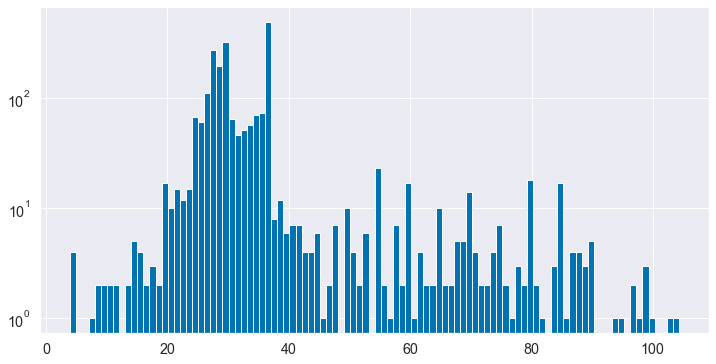

In [5]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(growth_temperatures, bins=100, log=True);

In [24]:
def compute_inverse_effective_sample(
    growth_temperatures, 
    batch_size,
    bins,
    beta=0.99,
):
    """
    Class-balanced weighting based on inverse effective sample.
    Effective sample = (1 - beta^n) / (1 - beta)
    Typical values of beta are 0.9, 0.99 or 0.999.
    https://arxiv.org/abs/1901.05555
    """
    values, _ = np.histogram(growth_temperatures, bins)
    inv_effective_sample_fn = lambda n: (1 - beta) / (1 - beta**n)
    inv_effective_weights = np.apply_along_axis(
        inv_effective_sample_fn, 
        axis=0, 
        arr=values,
    )
    ###
    # Factor inferred experimentally such that for a typical
    # batch, the sum of weights will equal the batch size.
    # A widely different distribution of temperatures would
    # lead to a different factor.
    # See notebook Sample weights.ipynb for calculation details.
    factor = 2.58844
    alpha = factor * batch_size
    ###
    weights_sum = np.sum(inv_effective_weights)
    weights_dict = {
        b: alpha * inv_effective_weights[i] / weights_sum
        for i, b in enumerate(bins[:-1])
    }
    return weights_dict

In [25]:
bins = np.array([
    4,   10,  16,  19,  22,  25,  28,  31,  34,  37,  40,
    43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,
    82,  85,  88,  91,  106,
])

In [26]:
weights_dict = compute_inverse_effective_sample(
    growth_temperatures, 
    batch_size=64,
    bins=bins,
    beta=0.999,
)

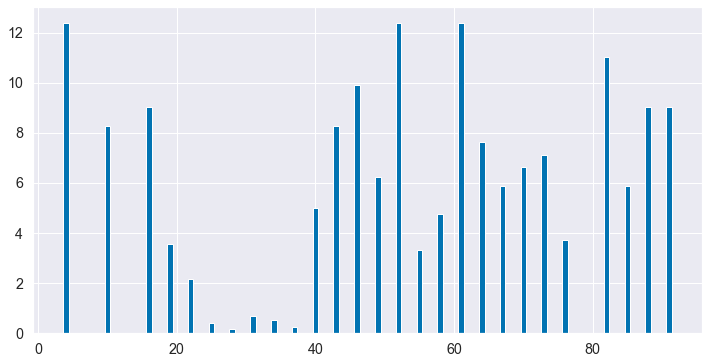

In [27]:
weights_values = [weights_dict[k] for k in sorted(weights_dict.keys())]
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    sorted(weights_dict.keys()),
    weights_values,
);

In [28]:
min_ = np.min(weights_values)
max_ = np.max(weights_values)
ratio = max_ / min_
print(f'min: {min_:.2f}')
print(f'max: {max_:.2f}')
print(f'ratio: {ratio:.2f}')

min: 0.18
max: 12.39
ratio: 67.96


In [20]:
def assign_weight_to_batch_values(
    batch_temperatures, 
    weights_dict, 
    bins, 
    dtype='float32',
):
    index = np.digitize(batch_temperatures, bins)
    return np.array(
        [weights_dict[bins[ix-1]] for ix in index],
        dtype=dtype,
    )

In [21]:
%%time
q = """
select t.growth_tmp 
from sequences as s 
inner join species_traits as t 
on t.species_taxid = s.species_taxid
"""
all_tmps = pd.read_sql(q, engine)['growth_tmp']

CPU times: user 13.4 s, sys: 1.31 s, total: 14.7 s
Wall time: 15 s


In [22]:
%%time
sums = []
n_samples = 1000
for i in range(n_samples):
    if (i+1) % 50 == 0:
        print(f'{i+1} / {n_samples}')
    batch_tmps = np.random.choice(all_tmps, size=64, replace=False)
    w = assign_weight_to_batch_values(batch_tmps, weights_dict, bins)
    sums.append(np.sum(w))
    
np.mean(sums)

50 / 1000
100 / 1000
150 / 1000
200 / 1000
250 / 1000
300 / 1000
350 / 1000
400 / 1000
450 / 1000
500 / 1000
550 / 1000
600 / 1000
650 / 1000
700 / 1000
750 / 1000
800 / 1000
850 / 1000
900 / 1000
950 / 1000
1000 / 1000
CPU times: user 9min 20s, sys: 10.4 s, total: 9min 31s
Wall time: 9min 40s


62.83074